In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv("data/cleaned_data.csv")

# EDA

In [3]:
df1["actual_sentiment"].value_counts(normalize=True, dropna=False) * 100

actual_sentiment
positive    43.501124
negative    42.413483
neutral     14.085393
Name: proportion, dtype: float64

In [4]:
df1["rating"].value_counts(normalize=True, dropna=False) * 100

rating
1    32.359551
5    27.577528
4    15.923596
3    14.085393
2    10.053933
Name: proportion, dtype: float64

In [5]:
df1["City"].value_counts(normalize=True, dropna=False) * 100

City
New York             11.775281
Orlando              10.022472
Austin                5.649438
Los Angeles           4.606742
Miami                 4.480899
Dallas                4.422472
Queens                4.274157
Kissimmee             4.224719
Las Vegas             4.170787
Salt Lake City        3.973034
San Diego             3.896629
North Hollywood       3.128090
Honolulu              2.930337
Sunnyvale             2.925843
Fern Park             2.921348
Newark                2.687640
Santa Monica          2.633708
Miami Beach           2.539326
San Antonio           2.525843
Oak Park              2.498876
Champlain             2.485393
Brodheadsville        2.301124
Washington            2.053933
Roanoke               2.013483
Voorhees Township     1.946067
Fort Worth            1.941573
Annandale             0.970787
Name: proportion, dtype: float64

In [6]:
df1["State"].value_counts(normalize=True, dropna=False) * 100

State
FL    24.188764
NY    18.534831
CA    17.191011
TX    16.552809
NJ     4.633708
NV     4.170787
UT     3.973034
HI     2.930337
IL     2.498876
PA     2.301124
DC     2.053933
VA     0.970787
Name: proportion, dtype: float64

# Sentiment Analyser

In [7]:
df2 = df1.copy(deep = True)

## Using NLTK’s Pre-Trained Sentiment Analyzer:

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer 


analyzer = SentimentIntensityAnalyzer()

#Sentiment score from -1 (very negative) to 1 (very positive)
df2['sentiment_score_SIA'] = df2['tokenized_reviews'].apply(lambda text: analyzer.polarity_scores(str(text))['compound'])
df2['sentiment_SIA'] = None

df2['sentiment_SIA'] = df2['sentiment_score_SIA'].apply(lambda score: 'positive' if score >= 0.4 else ('negative' if score <= -0.1 else 'neutral'))
print(df2[['sentiment_score_SIA', 'sentiment_SIA', 'actual_sentiment', "review"]].head())

   sentiment_score_SIA sentiment_SIA actual_sentiment  \
0               0.5541      positive         negative   
1               0.8591      positive         positive   
2              -0.2960      negative         negative   
3               0.0000       neutral         positive   
4              -0.7184      negative         negative   

                                              review  
0  Why does it look like someone spit on my food?...  
1  It'd McDonalds. It is what it is as far as the...  
2  Made a mobile order got to the speaker and che...  
3  My mc. Crispy chicken sandwich was ..............  
4  I repeat my order 3 times in the drive thru, a...  


<Figure size 800x600 with 0 Axes>

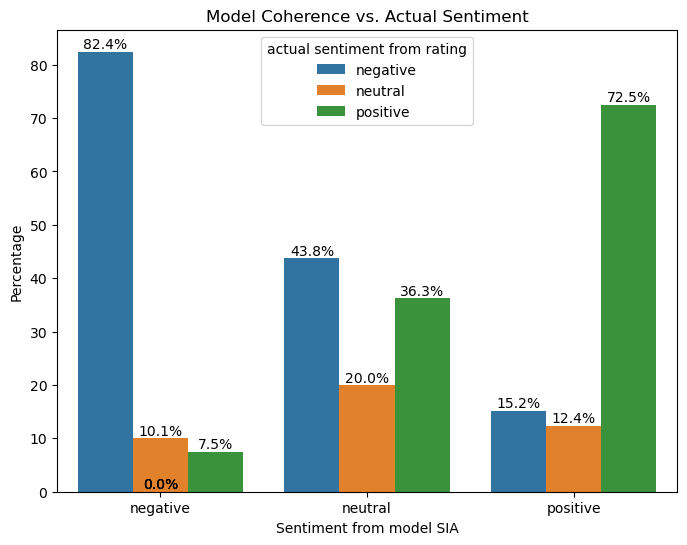

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Compute percentages and convert format for seaborn
rates = df2.groupby(['sentiment_SIA', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA', value_name='percentage')

# Creat graph
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA', y='percentage', hue='actual_sentiment')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title('Model Coherence vs. Actual Sentiment')
plt.xlabel('Sentiment from model SIA')
plt.ylabel('Percentage')
plt.legend(title='actual sentiment from rating')
plt.xticks(rotation=0)

plt.show()

## Model Text_classification from DistilBERT

In [10]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", framework="pt")
print(classifier("This should now work without TensorFlow."))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.8121552467346191}]


In [11]:
from transformers import pipeline
from tqdm.notebook import tqdm

pipe = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512) #model par défaut. tronqué car il ne support pas les reviews de plus de 512 tokens

reviews = df2["review"].tolist()

results = []
for review in tqdm(reviews, desc="Processing reviews"):
    result = pipe(review)
    results.append(result)

df2['DistilBERT'] = results

Device set to use cpu


Processing reviews:   0%|          | 0/22250 [00:00<?, ?it/s]

In [12]:
for i in df2.index:
    result = df2.loc[i, "DistilBERT"][0]
    df2.loc[i, "DistilBERT_sentiment"] = result["label"]
    df2.loc[i, "DistilBERT_score"] = result["score"]

df2 = df2.drop(["DistilBERT"], axis=1)

<Figure size 800x600 with 0 Axes>

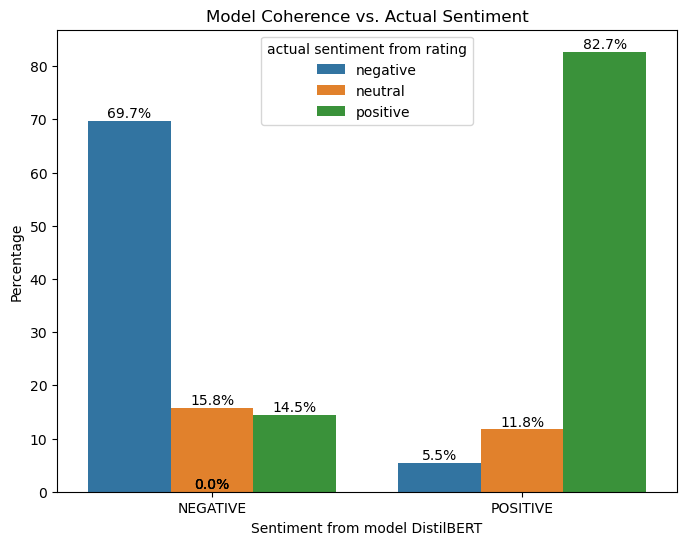

In [13]:
plt.figure(figsize=(8, 6))

# Calculate percentages
rates = df2.groupby(['DistilBERT_sentiment', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert rates to long format for seaborn
rates_long = rates.reset_index().melt(id_vars='DistilBERT_sentiment', value_name='percentage')

# Create bar plot with seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='DistilBERT_sentiment', y='percentage', hue='actual_sentiment')

# Add annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title('Model Coherence vs. Actual Sentiment')
plt.xlabel('Sentiment from model DistilBERT')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='actual sentiment from rating')
plt.show()


## Model RoBERTa

In [14]:
# Load model
from transformers import pipeline

# Initialize the sentiment analysis pipeline
model_roberta = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cpu


In [16]:
from tqdm.notebook import tqdm

# Define the maximum length
max_length = 514

# Store results in a list before assigning to the DataFrame (faster than df.at in loop)
roberta_outputs = []

for i, row in tqdm(df2.iterrows(), total=len(df2)):
    try:
        text = row.get('clean_reviews', '')

        # Skip if not a string
        if not isinstance(text, str):
            print(f"Skipping non-string value at index {i}: {text}")
            roberta_outputs.append({})
            continue

        # Truncate if necessary
        text = text[:max_length]

        # Run inference
        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if roberta_result and isinstance(roberta_result, list):
            for key, value in roberta_result[0].items():
                roberta_result_model[f'Roberta_{key}'] = value

        roberta_outputs.append(roberta_result_model)

    except RuntimeError as e:
        print(f"Runtime error at index {i}: {e}")
        roberta_outputs.append({})

# Assign the results to the DataFrame in one go (much faster)
df2["Roberta"] = roberta_outputs


  0%|          | 0/22250 [00:00<?, ?it/s]

In [17]:
# Create columns to store the extracted label and score from the Roberta results
df2["Roberta_label"] = None
df2["Roberta_score"] = None

# Extract values from the "Roberta" dictionary column into separate columns
for i, result in df2["Roberta"].items():
    if "Roberta_label" in result:
        df2.at[i, "Roberta_label"] = result["Roberta_label"]
        df2.at[i, "Roberta_score"] = result["Roberta_score"]

# Drop the original "Roberta" column now that the values are extracted
df2.drop("Roberta", axis=1, inplace=True)


In [18]:
# RoBERTa labeled results as: for negative review as LABEL_0, for neutral as LABEL_1, and for positive as LABEL_2
# Below is to map  the Labels as negative , neutral and positive

def map_roberta_labels(label):
    if label == 'LABEL_0':
        return 'negative'
    elif label == 'LABEL_1':
        return 'neutral'
    elif label == 'LABEL_2':
        return 'positive'
    else:
        return 'unknown'

# Apply the function to the 'Roberta_label' column
df2['Roberta_label'] = df2['Roberta_label'].apply(map_roberta_labels)

In [19]:
df2['Roberta_score'] = df2['Roberta_score'].astype(float)

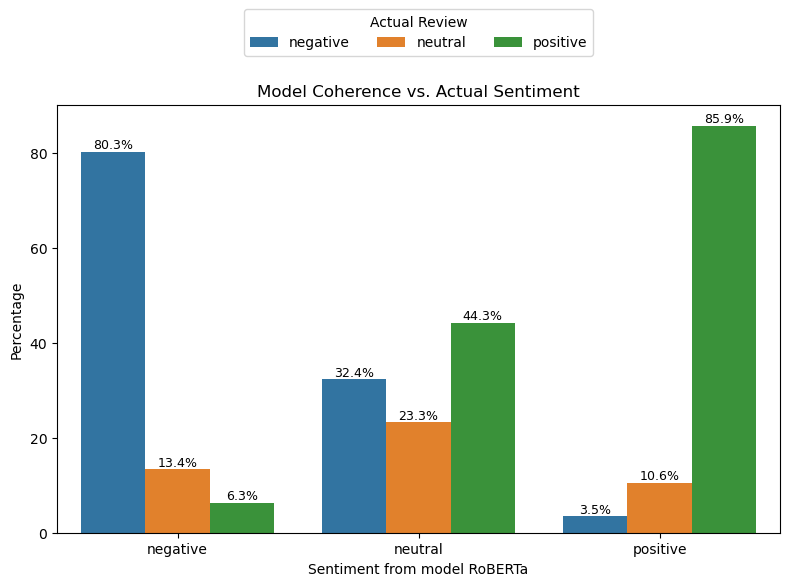

In [20]:
df_refults_filtered = df2.copy()

# Group and compute percentages
rates = df_refults_filtered.groupby(['Roberta_label', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='Roberta_label', value_name='percentage', var_name='actual_sentiment')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='Roberta_label', y='percentage', hue='actual_sentiment')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.title('Model Coherence vs. Actual Sentiment')
plt.xlabel('Sentiment from model RoBERTa')
plt.ylabel('Percentage')
plt.legend(title='Actual Review', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


RoBERTA model shows the best results

In [21]:
df2.to_csv("data/data_with_models_sentiment_analysis.csv")

In [22]:
df2.head()

,reviewer_id,store_address,latitude,longitude,City,State,review,rating,review_date,clean_reviews,tokenized_reviews,actual_sentiment,sentiment_score_SIA,sentiment_SIA,DistilBERT_sentiment,DistilBERT_score,Roberta_label,Roberta_score
0,1,13749 US-183 Hwy,30.460718,-97.792874,Austin,TX,Why does it look like someone spit on my food?...,1,2025-03-05,why does it look like someone spit on my food ...,look like someone spit food normal transaction...,negative,0.5541,positive,NEGATIVE,0.999151,negative,0.975279
1,2,13749 US-183 Hwy,30.460718,-97.792874,Austin,TX,It'd McDonalds. It is what it is as far as the...,4,2025-05-31,itd mcdonalds it is what it is as far as the f...,itd mcdonalds far food atmosphere go staff mak...,positive,0.8591,positive,POSITIVE,0.999840,positive,0.973995
2,3,13749 US-183 Hwy,30.460718,-97.792874,Austin,TX,Made a mobile order got to the speaker and che...,1,2025-05-31,made a mobile order got to the speaker and che...,made mobile order got speaker checked line mov...,negative,-0.2960,negative,NEGATIVE,0.999660,negative,0.775206
3,4,13749 US-183 Hwy,30.460718,-97.792874,Austin,TX,My mc. Crispy chicken sandwich was ..............,5,2025-05-05,my mc crispy chicken sandwich was customer ser...,mc crispy chicken sandwich customer service qu...,positive,0.0000,neutral,NEGATIVE,0.991270,positive,0.901184
4,5,13749 US-183 Hwy,30.460718,-97.792874,Austin,TX,"I repeat my order 3 times in the drive thru, a...",1,2025-04-05,i repeat my order times in the drive thru and ...,repeat order times drive thru still manage mes...,negative,-0.7184,negative,NEGATIVE,0.999598,negative,0.937037


# Cleaning dataset for dashboard

In [23]:
df3 = df2.copy(deep=True)

In [24]:
df3.columns

Index(['reviewer_id', 'store_address', 'latitude', 'longitude', 'City',
       'State', 'review', 'rating', 'review_date', 'clean_reviews',
       'tokenized_reviews', 'actual_sentiment', 'sentiment_score_SIA',
       'sentiment_SIA', 'DistilBERT_sentiment', 'DistilBERT_score',
       'Roberta_label', 'Roberta_score'],
      dtype='object')

In [25]:
df3=df3[["reviewer_id","store_address","City","State","longitude","latitude","review_date",'clean_reviews',"review","tokenized_reviews","rating","actual_sentiment","Roberta_label","Roberta_score"]]

In [26]:
df3.head()

,reviewer_id,store_address,City,State,longitude,latitude,review_date,clean_reviews,review,tokenized_reviews,rating,actual_sentiment,Roberta_label,Roberta_score
0,1,13749 US-183 Hwy,Austin,TX,-97.792874,30.460718,2025-03-05,why does it look like someone spit on my food ...,Why does it look like someone spit on my food?...,look like someone spit food normal transaction...,1,negative,negative,0.975279
1,2,13749 US-183 Hwy,Austin,TX,-97.792874,30.460718,2025-05-31,itd mcdonalds it is what it is as far as the f...,It'd McDonalds. It is what it is as far as the...,itd mcdonalds far food atmosphere go staff mak...,4,positive,positive,0.973995
2,3,13749 US-183 Hwy,Austin,TX,-97.792874,30.460718,2025-05-31,made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...,made mobile order got speaker checked line mov...,1,negative,negative,0.775206
3,4,13749 US-183 Hwy,Austin,TX,-97.792874,30.460718,2025-05-05,my mc crispy chicken sandwich was customer ser...,My mc. Crispy chicken sandwich was ..............,mc crispy chicken sandwich customer service qu...,5,positive,positive,0.901184
4,5,13749 US-183 Hwy,Austin,TX,-97.792874,30.460718,2025-04-05,i repeat my order times in the drive thru and ...,"I repeat my order 3 times in the drive thru, a...",repeat order times drive thru still manage mes...,1,negative,negative,0.937037


In [27]:
df3.to_csv("data/data_with_best_model_sentiment_analysis.csv")